### Introduction

The following cell sets up some functions and pulls in data for the first few exercises.  In the first exercise we'll explore the interaction of different dimensionality reduction strategies with k-means.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load the MNIST digit data
digits = datasets.load_digits()
X = digits.data
y = digits.target

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Visualization function
def visualize_clusters(X_2D, labels, title=""):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_2D[:, 0], X_2D[:, 1], c=labels, cmap='tab10', s=50, alpha=0.6, edgecolors='w')
    plt.title(title)
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    plt.colorbar(scatter)
    plt.show()



#### Step 1: Helper function for k-means evaluation

Build a function that takes some data, a min k-value, a max k value, and a title that plots three graphs showing davies-bouldin, silhouette, and inertia (elbow) for k-means. Once you're done, run the function on the raw data to establish a baseline.

In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt

def evaluate_clustering(data,min_k,max_k,title):
    k_values = range(min_k, max_k)
    inertias, silhouettes, db_scores = [], [], []

    for k in k_values:
        km = KMeans(n_clusters=k, n_init=10, random_state=42)
        labels = km.fit_predict(data)

        inertias.append(km.inertia_)
        silhouettes.append(silhouette_score(data, labels))
        db_scores.append(davies_bouldin_score(data, labels))

    # Plot the evaluation metrics
    plt.figure(figsize=(15,4))

    plt.subplot(1,3,1)
    plt.plot(k_values, inertias, marker='o')
    plt.title(f"{title}: Elbow method (Inertia)")
    plt.xlabel("k")
    plt.ylabel("Inertia")

    plt.subplot(1,3,2)
    plt.plot(k_values, silhouettes, marker='o')
    plt.title(f"{title}: Silhouette score")
    plt.xlabel("k")
    plt.ylabel("Score (higher is better)")

    plt.subplot(1,3,3)
    plt.plot(k_values, db_scores, marker='o')
    plt.title(f"{title}: Davies–Bouldin score")
    plt.xlabel("k")
    plt.ylabel("Score (lower is better)")

    plt.tight_layout()
    plt.show()

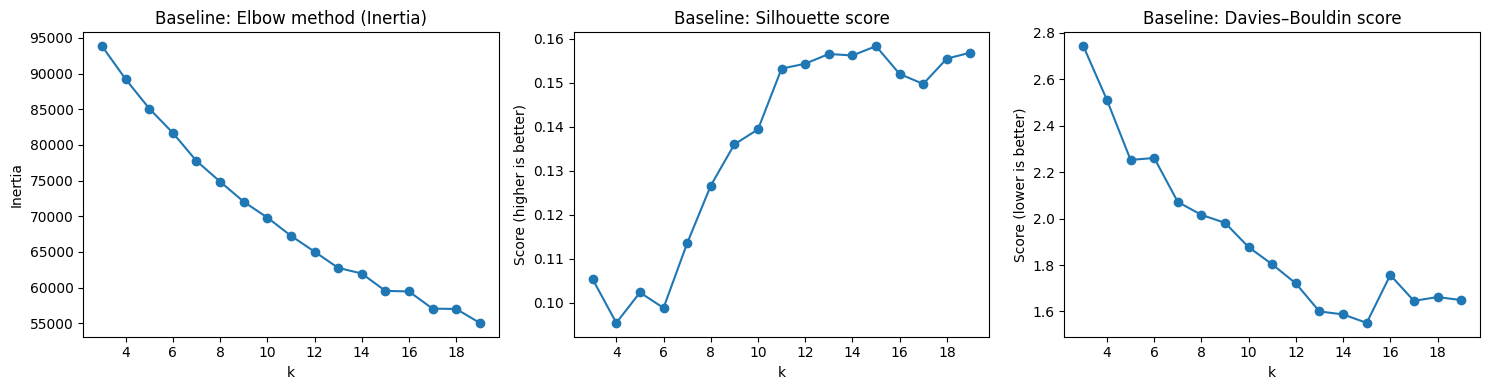

In [5]:
evaluate_clustering(X_scaled,3,20,"Baseline")

#### Step 2: Build a helper function to examine different numbers of dimensions

Build a function to that takes a set of named transformers (in the form of an array of tuples) and then uses the previous function to evaluate k-means clustering for each.  The system should generate a row of plots for each of the transformers used.  


In [12]:
def compare_transformers(transformers, X, min_k, max_k):
    """
    Apply evaluate_clustering to a list of transformers.

    Parameters
    ----------
    transformers : list of (str, transformer_class, kwargs_dict)
        Example:
            [
                ("PCA", PCA, {"n_components": 2}),
                ("t-SNE", TSNE, {"n_components": 2, "perplexity": 30}),
            ]
    X : array-like
        Input data
    min_k, max_k : int
        Range of k values to evaluate
    """
    for name, transformer in transformers:
        X_transformed = transformer.fit_transform(X)
        evaluate_clustering(X_transformed, min_k, max_k, title=name)

#### Step 3: Build a simple iterator to construct the list of transformers to test

Rather than write a bunch of stuff by hand, build a simple loop that constructs 9 different transformers - 3 each for PCA, UMAP, and t-SNE - at three levels of components.  e.g., try 2, 5, and 10 dimensions. This should generate the array of transformers required by the above.

Loop through this array to evaluate the different transformers and parameters - this should give you a 9 x 3 matrix of images you can use to make decisions about which transformer method you want to use.

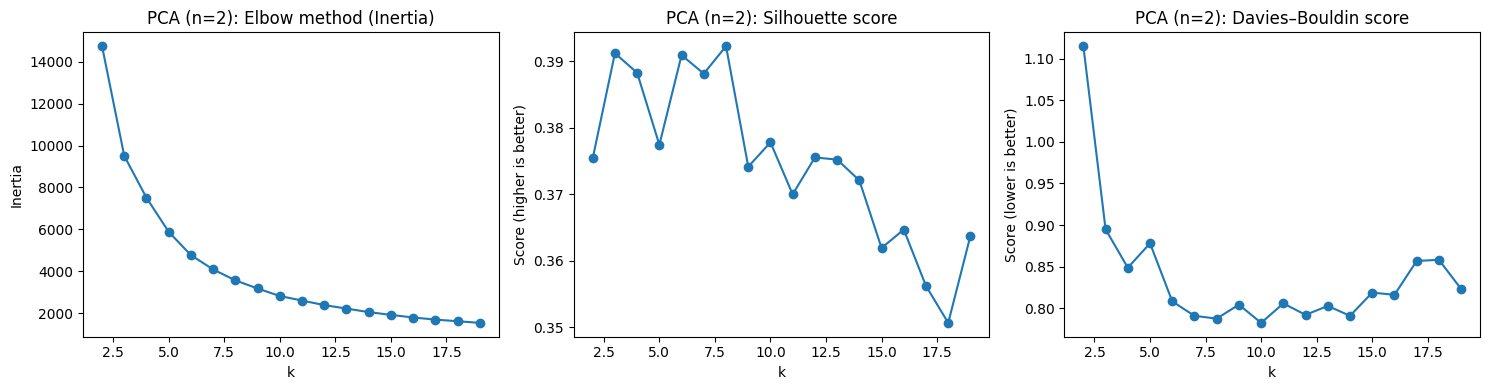

/Users/jeintron/Dropbox/@TEACHING/POR/ist707-aml-master/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


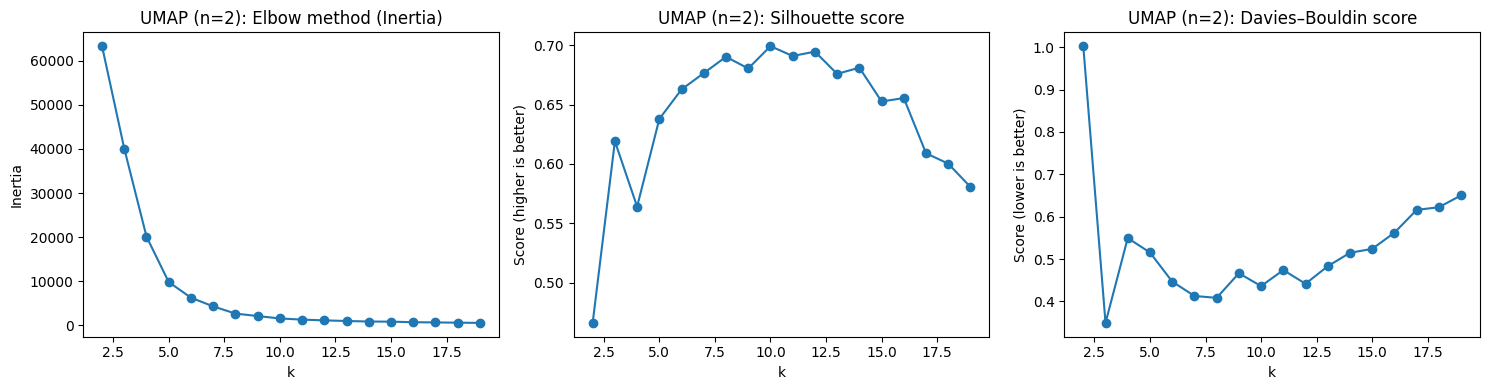

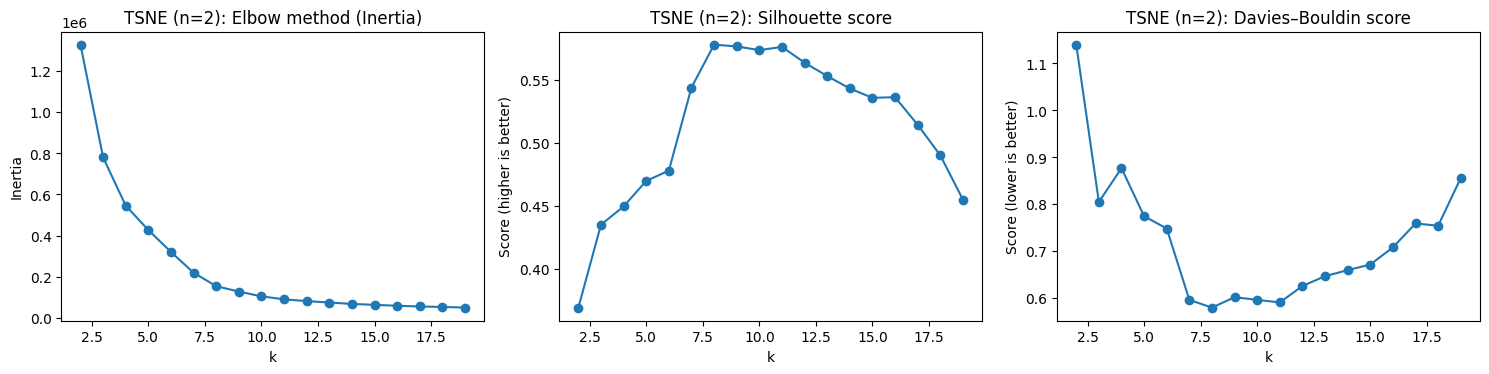

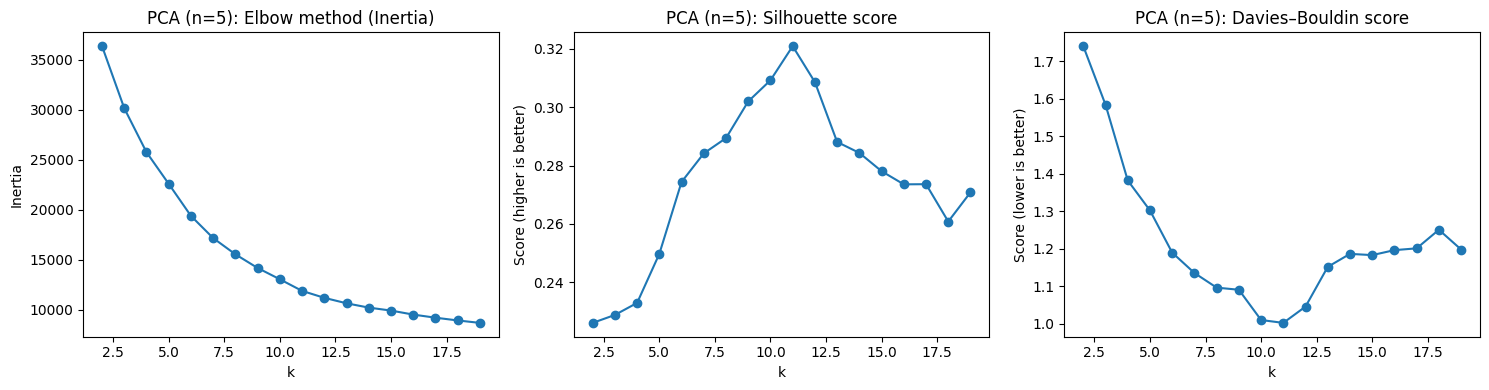

/Users/jeintron/Dropbox/@TEACHING/POR/ist707-aml-master/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


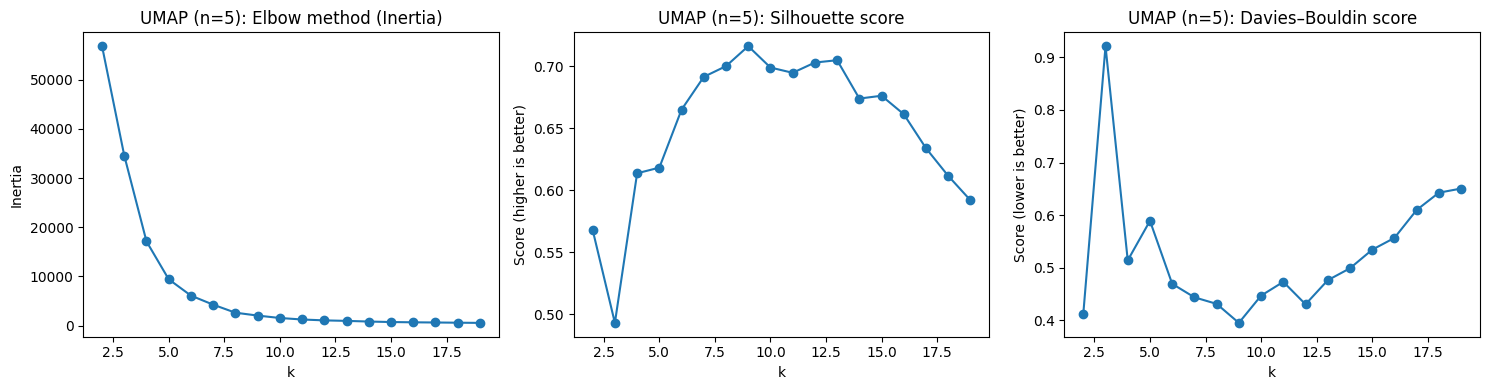

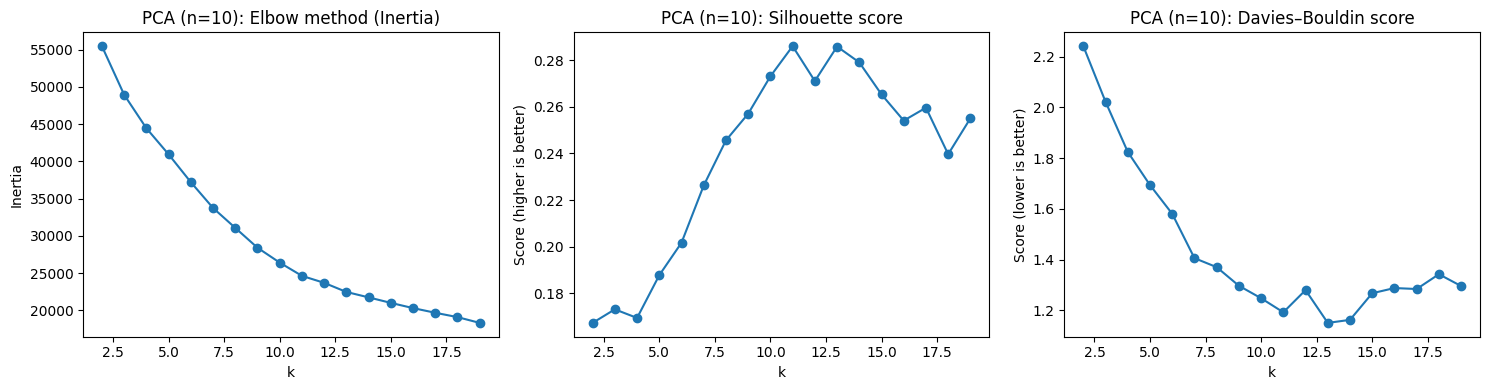

/Users/jeintron/Dropbox/@TEACHING/POR/ist707-aml-master/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


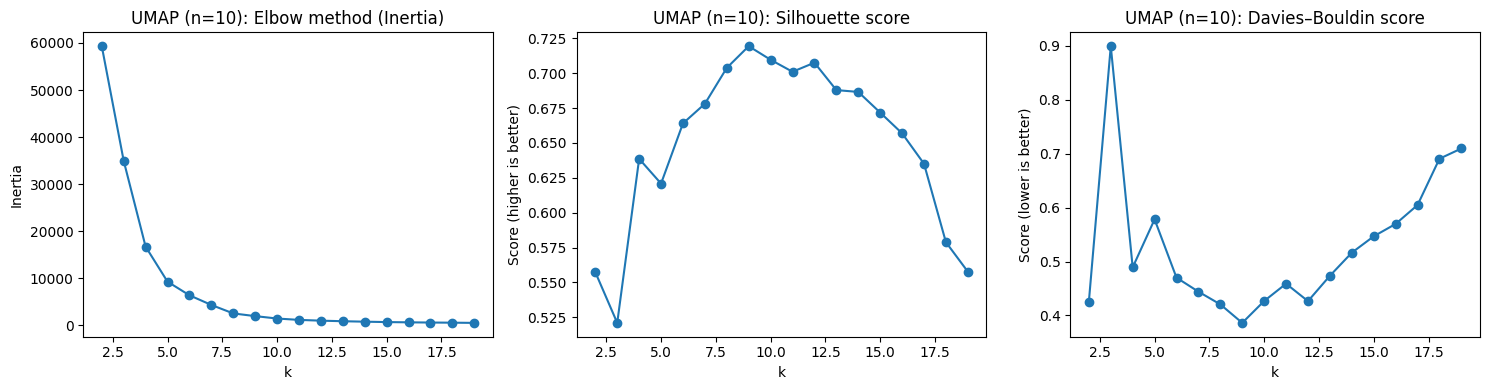

In [14]:
def build_transformers(n_components_list=(2, 5, 10)):
    """
    Return a list of (name, class, kwargs) tuples for PCA, UMAP (if available), and t-SNE,
    each at multiple n_components.
    """
    transformers = []

    # PCA variants

    for nc in n_components_list:
        transformers.append((f"PCA (n={nc})", PCA(n_components=nc,random_state=42)))
        transformers.append((f"UMAP (n={nc})", UMAP(n_components=nc,n_neighbors=15,min_dist=.1,random_state=42)))
        if nc < 5:
            transformers.append((f"TSNE (n={nc})", TSNE(n_components=nc,perplexity=30,init="pca",random_state=42)))
    return transformers
        
                            

transformers = build_transformers(n_components_list=[2, 5, 10])
compare_transformers(transformers,X_scaled,2,20)

#### Step 4: Visualize your results

Build a function that allows you to pass in a transformer class, a k-value, and a set of named arguments, ground truth labels, and inferred labels and visually compare ground truth to clustered data.  That is, the function will run clustering with projection method and parameters specified.  Then it will display two plots side by side using the projection method specified (PCA, UMAP, TSNE) to see how ground truth corresponds to the inferred clusters.  Use the function to inspect your "best" methods from the above.

To make things easier, you can use the following function to build your transformer with arbitrary parameters:

In [15]:
def new_transformer(cls, **kwargs):
    """
    Given a class (e.g. PCA) and kwargs, return a new instance.
    Example:
        t = new_transformer(PCA, n_components=2)
    """
    return cls(**kwargs)

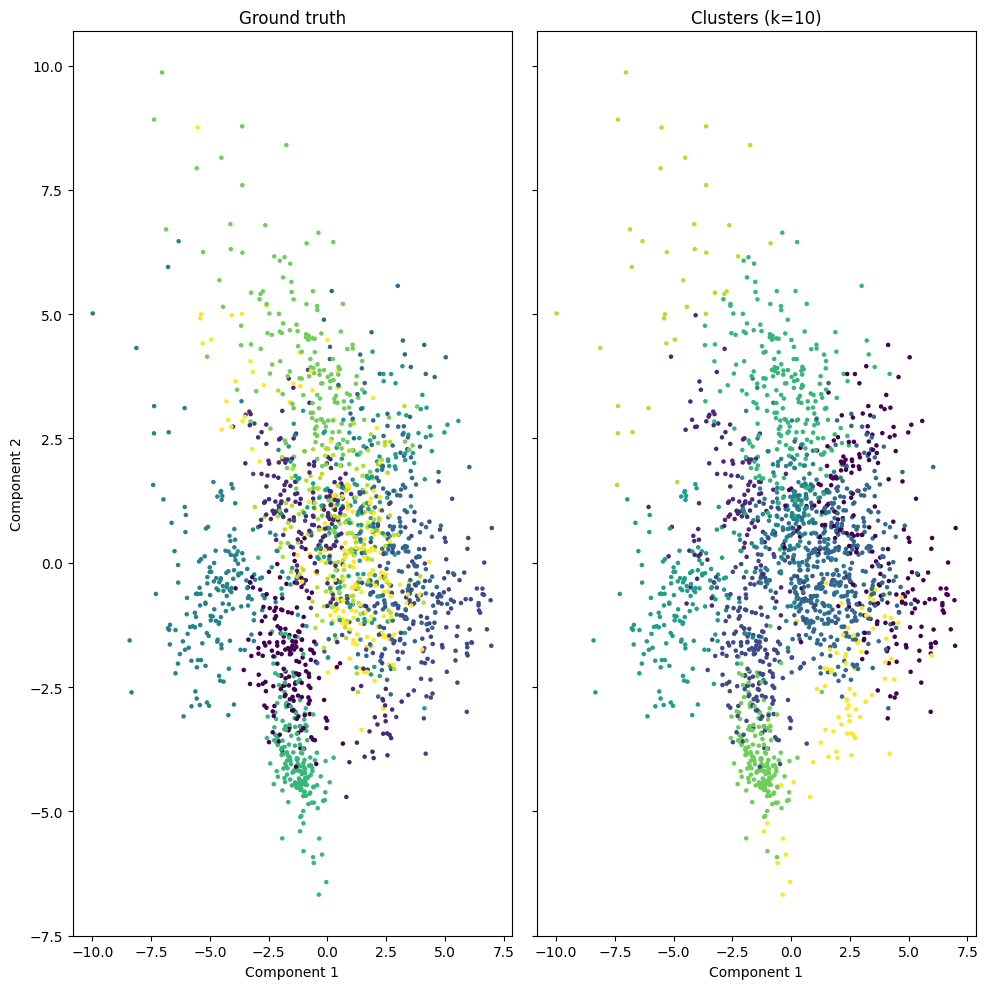

In [25]:
# Step 4 — Visual side-by-side comparison in a chosen projection space
# NOTE: answer-key code; do not execute here.

import copy
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def visualize_projection_vs_clusters(
    X,
    y_true,
    transformer_cls,
    n_clusters,
    transformer_kwargs=None,
):
    
    transformer_kwargs = transformer_kwargs or {}
    feat_tf = new_transformer(transformer_cls, **transformer_kwargs)
    Z_feat = feat_tf.fit_transform(X)  # features for clustering
    km = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    y_pred = km.fit_predict(Z_feat)


    # --- 3) Build a *separate* 2D transformer of the SAME class for visualization ---
    viz_kwargs = copy.deepcopy(transformer_kwargs)
    viz_kwargs["n_components"] = 2
    viz_tf = new_transformer(transformer_cls, **viz_kwargs)
    Z_2d = viz_tf.fit_transform(X)

    # --- 4) Plot side-by-side: ground truth vs inferred clusters ---
    fig, axes = plt.subplots(1, 2, figsize=(10, 10), sharex=True, sharey=True)

    axes[0].scatter(Z_2d[:, 0], Z_2d[:, 1], c=y_true, s=5)
    axes[0].set_title("Ground truth")
    axes[0].set_xlabel("Component 1")
    axes[0].set_ylabel("Component 2")

    axes[1].scatter(Z_2d[:, 0], Z_2d[:, 1], c=y_pred, s=5)
    axes[1].set_title(f"Clusters (k={n_clusters})")
    axes[1].set_xlabel("Component 1")

    plt.tight_layout()
    plt.show()

visualize_projection_vs_clusters(X_scaled,y,PCA,10,{"n_components":5,"random_state":42})

### Exercise 2

Using any one of the projected versions of MNIST handwriting data above, use the HAC method with different linkages and different cutoff levels to understand how the identified clusters vary over both of these hyper-parameters.  How does HAC compare with K-Means?  Which linkage do you prefer and why? 